In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Load model
MODEL_PATH= "output/SGDreg_128_256_conv_1024_dout_09_512_dout_07_256_dense/pt_80_10_10_lr_0.01_bs_64_ep_200/model.h5"
model = tf.keras.models.load_model(MODEL_PATH)

2023-11-17 12:32:51.491431: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-17 12:32:51.515892: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 12:32:51.924226: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-17 12:32:52.507123: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-11-17 12:32:52.507156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrievin

In [2]:
from src.dataloader import read_train, read_val
X_train, y_train = read_train("input/data/train_80_10_10")
X_val, y_val = read_val("input/data/train_80_10_10")

In [3]:
y_pred = model.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, y_pred))

217/217 [==============================] - 4s 17ms/step
0.8554130027389362


In [4]:
import src.config as config
output_shape = len(config.LABELS)
LEARNING_RATE = 0.0001
BATCH_SIZE = 64

layers = [
            keras.Input(shape=(config.IMG_SIZE, config.IMG_SIZE, config.N_CHANNELS)),
            keras.layers.Conv2D(32,(3,3), activation = 'relu', 
                                kernel_regularizer=keras.regularizers.l2(0.9)),
            keras.layers.MaxPooling2D(pool_size = (2, 2)),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(64,(3,3), activation = 'relu', 
                                kernel_regularizer=keras.regularizers.l2(0.9)),
            keras.layers.MaxPooling2D(pool_size = (2, 2)),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(128,(3,3), activation = 'relu', 
                                kernel_regularizer=keras.regularizers.l2(0.9)),
            keras.layers.BatchNormalization(),

            keras.layers.Flatten(),
            keras.layers.Dense(1024, activation='relu'),
            keras.layers.Dropout(0.9),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(output_shape, activation='softmax')
]

model = keras.Sequential(layers)

model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
## Train model
from src.preprocessing import CustomDataGenerator

EPOCHS = 200
train_generator = CustomDataGenerator(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = CustomDataGenerator(X_val, y_val, batch_size=BATCH_SIZE)
print(type(X_train))

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, restore_best_weights=True)

model.fit(train_generator,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS, 
          validation_data=val_generator, 
          callbacks=[early_stopping])


<class 'numpy.ndarray'>
Epoch 1/200
109/109 [==============================] - 2s 18ms/step - loss: 47.8436 - accuracy: 0.1139 - val_loss: 41.8982 - val_accuracy: 0.1430
Epoch 2/200
109/109 [==============================] - 2s 19ms/step - loss: 36.7674 - accuracy: 0.2070 - val_loss: 32.5953 - val_accuracy: 0.1326
Epoch 3/200
109/109 [==============================] - 2s 17ms/step - loss: 28.3978 - accuracy: 0.2269 - val_loss: 25.3172 - val_accuracy: 0.2076
Epoch 4/200
109/109 [==============================] - 2s 16ms/step - loss: 22.0014 - accuracy: 0.2518 - val_loss: 19.6313 - val_accuracy: 0.2549
Epoch 5/200
109/109 [==============================] - 2s 16ms/step - loss: 17.0973 - accuracy: 0.2665 - val_loss: 15.2362 - val_accuracy: 0.3253
Epoch 6/200
109/109 [==============================] - 2s 16ms/step - loss: 13.4125 - accuracy: 0.2885 - val_loss: 11.8880 - val_accuracy: 0.3691
Epoch 7/200
109/109 [==============================] - 2s 17ms/step - loss: 10.6184 - accuracy: 0.30

In [6]:
model

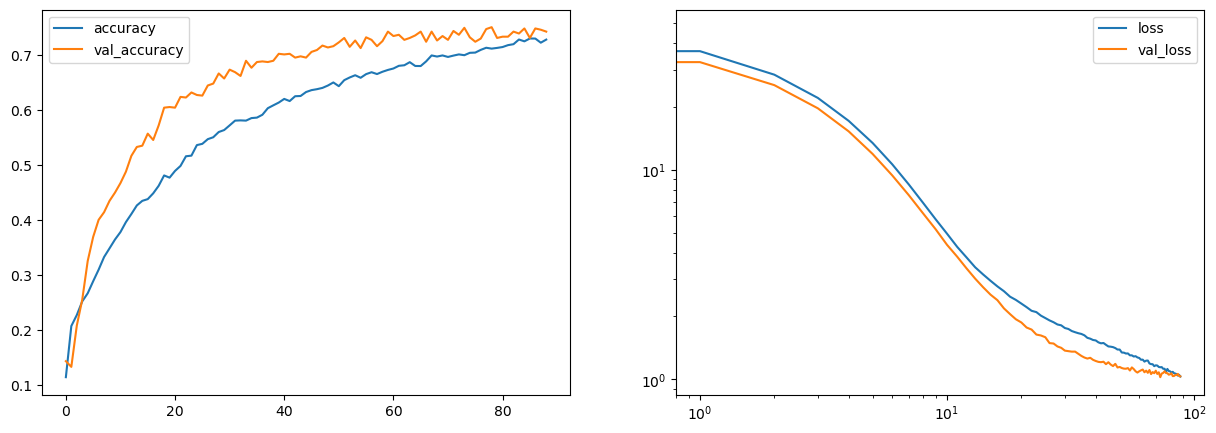

In [7]:
from src.results import plot_history, plot_history_logloss
plot_history_logloss(model);

In [8]:
y_pred = model.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, y_pred))

217/217 [==============================] - 2s 8ms/step
0.8205276055931959


In [9]:
model.evaluate(train_generator)

109/109 [==============================] - 1s 6ms/step - loss: 0.7024 - accuracy: 0.8205


[0.7024078965187073, 0.8205276131629944]

In [10]:
model.evaluate(val_generator)

14/14 [==============================] - 0s 5ms/step - loss: 1.0245 - accuracy: 0.7497


[1.0245367288589478, 0.7497116327285767]

In [11]:
from src.dataloader import read_test
X_test, y_test = read_test("input/data/train_80_10_10")

In [12]:
model.evaluate(X_test, y_test)

28/28 [==============================] - 0s 4ms/step - loss: 1.2378 - accuracy: 0.7001


[1.2378149032592773, 0.7001153230667114]